# Modeling Crop Yield: Landsat + Sentinel
## Python modules

In [1]:
## import warnings
import time
import math
import os
import glob
from pyhere import here
from datetime import date
import re

import numpy as np
import pandas as pd
import geopandas
import pickle

import pyarrow
import itertools
import multiprocessing
import p_tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, LeaveOneGroupOut, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score
from scipy.stats import spearmanr,  pearsonr

In [2]:
def split_fn(file_name):
    f            = file_name.split(sep="_")
    satellite    = f[0],
    bands        = f[1].replace("bands-", "")
    country_code = f[2],
    points       = f[3].replace("k-points", "")
    num_features = f[4].replace("-features", "")
    yrs          = f[5].replace("yr-", "")
    mns          = f[6].replace("mn-", "")
    limit_months = f[7].replace("lm-", "")
    crop_mask    = f[8].replace("cm-", "")
    weighted_avg = f[9].replace("wa-", "")
    
    return satellite, bands, country_code, points, yrs, mns, num_features, limit_months, crop_mask, weighted_avg

def merge(x, bases = (tuple, list)):
    for e in x:
        if type(e) in bases:
            for e in merge(e, bases):
                yield e
        else:
            yield e

In [3]:
files = os.listdir(here("data", "random_features", 'summary'))
files = [f for f in files if f not in ('.gitkeep', '.ipynb_checkpoints')]
paramlist = list(itertools.product(files, files))
paramlist = [tuple(set(paramlist[i])) for i in range(len(paramlist))]
paramlist = [x for x in paramlist if len(x) > 1] 
point_pattern = re.compile("20k-points")
wa_pattern = re.compile("cm-False")
paramlist = [t for t in paramlist if not (bool(point_pattern.search(t[0])) & bool(wa_pattern.search(t[0])))]
paramlist = [t for t in paramlist if not (bool(point_pattern.search(t[1])) & bool(wa_pattern.search(t[1])))]
paramlist = list(set(tuple(sorted(s)) for s in paramlist))
len(paramlist)

946

In [4]:
def model_2_sensors(params):
#########################################     SET PARAMS    #########################################    
    f1         = params[0]
    f2         = params[1]

    satellite1, bands1, country_code, points1, yrs1, mns1,\
    num_features1, limit_months1, crop_mask1, weighted_avg1 = split_fn(f1)
    
    satellite2, bands2, country_code, points2, yrs2, mns2,\
    num_features2, limit_months2, crop_mask2, weighted_avg2 = split_fn(f2)

#########################################     READ DATA    #########################################
    features_1 = pd.read_feather(here('data', 'random_features', 'summary', f1))
    features_2 = pd.read_feather(here('data', 'random_features', 'summary', f2))
    
#########################################     CLEAN DATA    #########################################  
    min_year = max(min(features_1.year), min(features_2.year))
    max_year = min(max(features_1.year), max(features_2.year))
    
    features_1 = features_1[features_1.year >= min_year]
    features_2 = features_2[features_2.year >= min_year]
    
    features_1 = features_1[features_1.year <= max_year]
    features_2 = features_2[features_2.year <= max_year]
    
    features_1.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)
    features_2.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)
    
#########################################     JOIN DATA    #########################################  
    drop_cols = ['district', 'year', 'yield_mt']
    
    features_1 = features_1.set_index(drop_cols).add_prefix("f1_")
    features_2 = features_2.set_index(drop_cols).add_prefix("f2_")
    
    features = features_1.join(features_2).reset_index()
    features = features[~features.isna().any(axis = 1)]

#########################################    STANDARDIZE FEATURES    #########################################    
    features = features.set_index(drop_cols) 
    features_scaled = StandardScaler().fit_transform(features.values)
    features = pd.DataFrame(features_scaled, index=features.index).reset_index()

#########################################     CALCULATE ANOMALY   #########################################  
    features['yield_mt'] = np.log10(features.yield_mt + 1)
    features.set_index(['year', 'district'], inplace=True)
    var_cols = features.columns
    features = features[var_cols] - features.groupby(['district'], as_index=True)[var_cols].transform('mean')
    features.reset_index(drop=False, inplace=True)

#########################################     K-FOLD SPLIT    #########################################    
    x_all = features.drop(drop_cols, axis=1)
    y_all = features.yield_mt
    x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

#########################################     K-FOLD CV   ###########################################  
    ### SETUP
    alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
    kfold  = KFold()
    ridge  = Ridge()    
    
    ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
    kfold_ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
    kfold_ridge_reg.fit(x_train, y_train)
    kfold_best_model = kfold_ridge_reg.best_estimator_
    ### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
    kfold_val_predictions = cross_val_predict(kfold_best_model, X = x_train, y = y_train, cv = kfold)   
    y_pred_train_k = kfold_best_model.predict(x_train)
    y_pred_test_k  = kfold_best_model.predict(x_test)

#########################################     SAVE RESULTS    #########################################
    d = {
        'country': country_code,
        
        'satellite_1'   : satellite1[0],
        'bands_1'       : bands1,
        'num_features_1': num_features1,
        'points_1'      : points1, 
        'month_range_1' : mns1,
        'limit_months_1': limit_months1,
        'crop_mask_1'   : crop_mask1,
        'weighted_avg_1': weighted_avg1,
        
        'satellite_2'   : satellite2[0],
        'bands_2'       : bands2,
        'num_features_2': num_features2,
        'points_2'      : points2, 
        'month_range_2' : mns2,
        'limit_months_2': limit_months2,
        'crop_mask_2'   : crop_mask2,
        'weighted_avg_2': weighted_avg2,

        'kfold_total_n': len(x_all),
        'kfold_train_n': len(x_train),
        'kfold_test_n' : len(x_test),
        
        'kfold_best_reg_param': list(kfold_ridge_reg.best_params_.values())[0],
        'kfold_mean_of_val_R2s': kfold_ridge_reg.best_score_,
        'kfold_val_R2': r2_score(y_train, kfold_val_predictions),
        'kfold_val_r' : pearsonr(kfold_val_predictions, y_train)[0],
        'kfold_val_r2': pearsonr(kfold_val_predictions, y_train)[0] ** 2,
        
        'kfold_train_R2': r2_score(y_train, y_pred_train_k),
        'kfold_train_r' : pearsonr(y_pred_train_k, y_train)[0],
        'kfold_train_r2': pearsonr(y_pred_train_k, y_train)[0] ** 2,
        
        'kfold_test_R2': r2_score(y_test, y_pred_test_k),
        'kfold_test_r' : pearsonr(y_pred_test_k, y_test)[0],
        'kfold_test_r2': pearsonr(y_pred_test_k, y_test)[0] ** 2,
    }
    df = pd.DataFrame(data=d)
    return df

In [5]:
%%time     
##### With progress bar
workers = os.cpu_count()
if __name__ == "__main__":
    output = []
    for result in p_tqdm.p_umap(model_2_sensors, paramlist):
        output.append(result)
    results = pd.concat(output).reset_index(drop=True)
    today = date.today().strftime("%Y-%m-%d")
    file_name = f'2_sensor_anomaly_results_{today}.csv'
    print(f"Saving results as: {file_name}\n\n")           
    results.to_csv(here("data","results", file_name), index=False)

  0%|          | 0/946 [00:00<?, ?it/s]

Saving results as: 2_sensor_anomaly_results_2022-12-19.csv


CPU times: user 10.1 s, sys: 1.74 s, total: 11.9 s
Wall time: 2h 3min 35s


In [ ]:
# results

In [6]:
res = pd.read_csv(here('data', 'results', '2_sensor_anomaly_results_2022-12-18.csv'))

In [11]:
res

,country,satellite_1,bands_1,num_features_1,points_1,month_range_1,limit_months_1,crop_mask_1,weighted_avg_1,satellite_2,...,kfold_mean_of_val_R2s,kfold_val_R2,kfold_val_r,kfold_val_r2,kfold_train_R2,kfold_train_r,kfold_train_r2,kfold_test_R2,kfold_test_r,kfold_test_r2
0,ZMB,landsat-8-c2-l2,1-2-3-4-5-6-7,1000,15,4-9,True,True,True,sentinel-2-l2a,...,0.438771,0.479468,0.693876,0.481464,0.845214,0.930470,0.865774,0.339655,0.604542,0.365471
1,ZMB,landsat-c2-l2,r-g-b-nir-swir16-swir22,1024,20,4-9,True,True,False,sentinel-2-l2a,...,0.580604,0.608758,0.780461,0.609120,0.874721,0.941559,0.886534,0.455358,0.677919,0.459575
2,ZMB,landsat-8-c2-l2,1-2-3-4-5-6-7,1000,15,1-12,False,False,False,sentinel-2-l2a,...,0.501757,0.537902,0.742943,0.551964,0.996305,0.998572,0.997146,0.781797,0.885110,0.783420
3,ZMB,landsat-8-c2-l2,1-2-3-4-5-6-7,1000,15,1-12,False,True,False,sentinel-2-l2a,...,0.475117,0.513731,0.716813,0.513820,0.925175,0.969437,0.939807,0.657548,0.813661,0.662044
4,ZMB,landsat-8-c2-l2,1-2-3-4-5-6-7,1000,15,1-12,False,True,False,sentinel-2-l2a,...,0.475431,0.517862,0.738110,0.544806,0.993549,0.997370,0.994746,0.634461,0.804901,0.647865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,ZMB,sentinel-2-l2a,2-3-4,1000,20,1-12,False,True,False,sentinel-2-l2a,...,0.375635,0.389482,0.626318,0.392274,0.643748,0.824539,0.679865,0.481794,0.718660,0.516473
942,ZMB,landsat-8-c2-l2,1-2-3-4-5-6-7,1000,15,1-12,False,True,False,sentinel-2-l2a,...,0.550934,0.577928,0.768250,0.590207,0.998566,0.999418,0.998837,0.822064,0.907992,0.824450
943,ZMB,sentinel-2-l2a,2-3-4,1000,15,1-12,False,True,True,sentinel-2-l2a,...,0.369659,0.394439,0.629063,0.395721,0.672464,0.831176,0.690853,0.518994,0.734686,0.539763
944,ZMB,landsat-8-c2-l2,1-2-3-4-5-6-7,1000,20,1-12,False,True,False,sentinel-2-l2a,...,0.536866,0.581843,0.768842,0.591118,0.998463,0.999346,0.998693,0.722089,0.854947,0.730934


In [12]:
sort_cols = ['satellite_1', 'bands_1', 'points_1', 'month_range_1', 'limit_months_1', 'crop_mask_1', 'weighted_avg_1',
            'satellite_2', 'bands_2', 'points_2', 'month_range_2', 'limit_months_2', 'crop_mask_2', 'weighted_avg_2']
results.sort_values(by=sort_cols, inplace=True)
res.sort_values(by=sort_cols, inplace=True)

In [13]:
np.mean(results['kfold_val_R2'] - res['kfold_val_R2'])

-0.00822772659415705

In [14]:
max(results['kfold_val_R2'] - res['kfold_val_R2'])

0.310357488860665

In [15]:
min(results['kfold_val_R2'] - res['kfold_val_R2'])

-0.3738972302605017

In [19]:
max(results['kfold_val_R2']), max(res['kfold_val_R2'])

(0.6519752990790046, 0.6588362519240656)

In [26]:
results['kfold_val_R2'] -res['kfold_val_R2']

0     -0.029040
1     -0.070692
2     -0.243790
3     -0.020986
4     -0.095541
         ...   
941    0.162189
942   -0.182106
943    0.034543
944   -0.196151
945    0.141813
Name: kfold_val_R2, Length: 946, dtype: float64

In [27]:
import matplotlib.pyplot as plt

(array([ 1.,  0.,  1.,  1.,  2.,  7.,  4.,  5.,  3.,  9.,  9.,  9., 10.,
        19., 17., 25., 30., 14., 21., 31., 33., 41., 31., 36., 46., 41.,
        54., 45., 42., 42., 26., 29., 16., 31., 26., 22., 29., 15., 19.,
        20., 20., 13.,  7., 11.,  7.,  8.,  9.,  4.,  1.,  4.]),
 array([-0.37389723, -0.36021214, -0.34652704, -0.33284195, -0.31915685,
        -0.30547176, -0.29178666, -0.27810157, -0.26441648, -0.25073138,
        -0.23704629, -0.22336119, -0.2096761 , -0.195991  , -0.18230591,
        -0.16862081, -0.15493572, -0.14125063, -0.12756553, -0.11388044,
        -0.10019534, -0.08651025, -0.07282515, -0.05914006, -0.04545497,
        -0.03176987, -0.01808478, -0.00439968,  0.00928541,  0.02297051,
         0.0366556 ,  0.0503407 ,  0.06402579,  0.07771088,  0.09139598,
         0.10508107,  0.11876617,  0.13245126,  0.14613636,  0.15982145,
         0.17350655,  0.18719164,  0.20087673,  0.21456183,  0.22824692,
         0.24193202,  0.25561711,  0.26930221,  0.2829873 ,

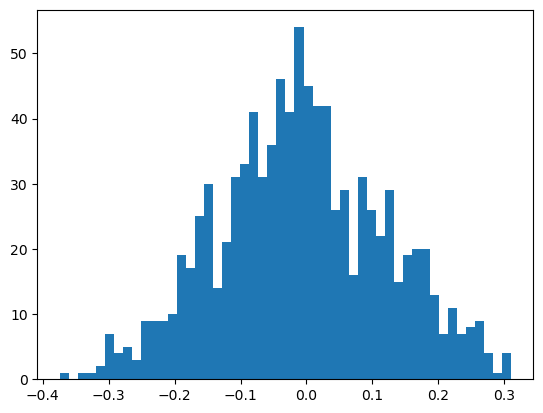

In [30]:
plt.hist(results['kfold_val_R2'] -res['kfold_val_R2'], bins = 50)

In [22]:
results[results.kfold_val_R2 ==max(results['kfold_val_R2'])].iloc[:, 0:19]

,country,satellite_1,bands_1,num_features_1,points_1,month_range_1,limit_months_1,crop_mask_1,weighted_avg_1,satellite_2,bands_2,num_features_2,points_2,month_range_2,limit_months_2,crop_mask_2,weighted_avg_2,kfold_total_n,kfold_train_n
642,ZMB,landsat-c2-l2,r-g-b-nir-swir16-swir22,1024,20,1-12,False,True,False,sentinel-2-l2a,2-3-4,1000,4,1-12,False,False,False,420,336


In [24]:
res[res.kfold_val_R2 ==max(res['kfold_val_R2'])].iloc[:, 0:19]

,country,satellite_1,bands_1,num_features_1,points_1,month_range_1,limit_months_1,crop_mask_1,weighted_avg_1,satellite_2,bands_2,num_features_2,points_2,month_range_2,limit_months_2,crop_mask_2,weighted_avg_2,kfold_total_n,kfold_train_n
416,ZMB,landsat-c2-l2,r-g-b-nir-swir16-swir22,1024,20,4-9,True,True,False,sentinel-2-l2a,2-3-4,1000,4,1-12,False,True,False,426,340


In [16]:
%%time
## TESTING  
f1 = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-False_wa-False_summary.feather'
f2 = 'sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_yr-2016-2022_mn-1-12_lm-False_cm-True_wa-False_summary.feather'
#########################################     SET PARAMS    #########################################    
# f1         = params[0]
# f2         = params[1]

satellite1, bands1, country_code, points1, yrs1, mns1,\
num_features1, limit_months1, crop_mask1, weighted_avg1 = split_fn(f1)

satellite2, bands2, country_code, points2, yrs2, mns2,\
num_features2, limit_months2, crop_mask2, weighted_avg2 = split_fn(f2)

#########################################     READ DATA    #########################################
features_1 = pd.read_feather(here('data', 'random_features', 'summary', f1))
features_2 = pd.read_feather(here('data', 'random_features', 'summary', f2))

#########################################     CLEAN DATA    #########################################  
min_year = max(min(features_1.year), min(features_2.year))
max_year = min(max(features_1.year), max(features_2.year))

features_1 = features_1[features_1.year >= min_year]
features_2 = features_2[features_2.year >= min_year]

features_1 = features_1[features_1.year <= max_year]
features_2 = features_2[features_2.year <= max_year]

features_1.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)
features_2.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)

#########################################     JOIN DATA    #########################################  
drop_cols = ['district', 'year', 'yield_mt']

features_1 = features_1.set_index(drop_cols).add_prefix("f1_")
features_2 = features_2.set_index(drop_cols).add_prefix("f2_")

features = features_1.join(features_2).reset_index()
features = features[~features.isna().any(axis = 1)]

#########################################    STANDARDIZE FEATURES    #########################################    
features = features.set_index(drop_cols) 
features_scaled = StandardScaler().fit_transform(features.values)
features = pd.DataFrame(features_scaled, index=features.index).reset_index()

#########################################     CALCULATE ANOMALY   #########################################  
features['yield_mt'] = np.log10(features.yield_mt + 1)
features.set_index(['year', 'district'], inplace=True)
var_cols = features.columns
features = features[var_cols] - features.groupby(['district'], as_index=True)[var_cols].transform('mean')
features.reset_index(drop=False, inplace=True)

#########################################     K-FOLD SPLIT    #########################################    
x_all = features.drop(drop_cols, axis=1)
y_all = features.yield_mt
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

#########################################     K-FOLD CV   ###########################################  
### SETUP
alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
kfold  = KFold()
ridge  = Ridge()    

### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
kfold_ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
kfold_ridge_reg.fit(x_train, y_train)
kfold_best_model = kfold_ridge_reg.best_estimator_
### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
kfold_val_predictions = cross_val_predict(kfold_best_model, X = x_train, y = y_train, cv = kfold)   
y_pred_train_k = kfold_best_model.predict(x_train)
y_pred_test_k  = kfold_best_model.predict(x_test)


crop_yield = features.copy().loc[:, tuple(drop_cols)]
crop_yield.rename(columns={"yield_mt": "yield_anom"}, inplace = True)
crop_yield["prediction"] = kfold_best_model.predict(x_all)

CPU times: user 3min 9s, sys: 9min 36s, total: 12min 45s
Wall time: 26.7 s


In [17]:
crop_yield

,district,year,yield_anom,prediction
0,Chadiza,2016,-0.045009,-0.020617
1,Chadiza,2017,0.085299,0.024634
2,Chadiza,2018,-0.142270,-0.088871
3,Chadiza,2019,-0.008178,-0.039893
4,Chadiza,2020,0.055630,0.074157
...,...,...,...,...
415,Zambezi,2017,-0.040316,-0.010536
416,Zambezi,2018,-0.017917,-0.004161
417,Zambezi,2019,-0.097159,-0.070309
418,Zambezi,2020,-0.006903,0.004850


In [18]:
r2_score(y_train, kfold_val_predictions)

0.5346156332897176

In [19]:
r2_score(y_test, y_pred_test_k)

0.5871415564070523

In [23]:
predictions = pd.concat([x_train, x_test])
predictions['split'] = np.concatenate((np.repeat('train', len(x_train)), np.repeat('test', len(x_test))))
predictions['kfold_cv_predictions'] = np.concatenate((kfold_val_predictions,  np.repeat(np.nan, len(x_test))))
predictions = predictions[['split', 'kfold_cv_predictions']]
predictions = crop_yield.join(predictions)
predictions

,district,year,yield_anom,prediction,split,kfold_cv_predictions
0,Chadiza,2016,-0.045009,-0.020617,train,0.007726
1,Chadiza,2017,0.085299,0.024634,test,NaN
2,Chadiza,2018,-0.142270,-0.088871,train,-0.033522
3,Chadiza,2019,-0.008178,-0.039893,train,-0.056811
4,Chadiza,2020,0.055630,0.074157,test,NaN
...,...,...,...,...,...,...
415,Zambezi,2017,-0.040316,-0.010536,train,0.014456
416,Zambezi,2018,-0.017917,-0.004161,train,0.008617
417,Zambezi,2019,-0.097159,-0.070309,train,-0.054833
418,Zambezi,2020,-0.006903,0.004850,train,0.024981


In [24]:
cv_pred = predictions[predictions.split == 'train']
r2_score(cv_pred.yield_anom, cv_pred.kfold_cv_predictions)

0.5346156332897178

In [27]:
test_pred = predictions[predictions.split == 'test']
r2_score(test_pred.yield_anom, test_pred.prediction)

0.5871415564070519

In [29]:
fn_1 = f'{satellite1[0]}_{bands1}_{points1}_{limit_months1}_{crop_mask1}_{weighted_avg1}'
fn_2 = f'{satellite2[0]}_{bands2}_{points2}_{limit_months2}_{crop_mask2}_{weighted_avg2}'
fn = f'anomaly-predictions_fn-1_{fn_1}_fn-2_{fn_2}.csv'
    
predictions_fn = here('data', 'results', fn)
predictions.to_csv(predictions_fn, index=False)

fn

'anomaly-predictions_fn-1_landsat-8-c2-l2_1-2-3-4-5-6-7_15_True_False_False_fn-2_sentinel-2-l2a_2-3-4-8_15_False_True_False.csv'

In [30]:
%%time
## TESTING  
f1 = 'landsat-c2-l2_bands-r-g-b-nir-swir16-swir22_ZMB_20k-points_1024-features_yr-2009-2021_mn-4-9_lm-True_cm-True_wa-False_summary.feather'
f2 = 'sentinel-2-l2a_bands-2-3-4_ZMB_4k-points_1000-features_yr-2016-2022_mn-1-12_lm-False_cm-True_wa-False_summary.feather'
#########################################     SET PARAMS    #########################################    
# f1         = params[0]
# f2         = params[1]

satellite1, bands1, country_code, points1, yrs1, mns1,\
num_features1, limit_months1, crop_mask1, weighted_avg1 = split_fn(f1)

satellite2, bands2, country_code, points2, yrs2, mns2,\
num_features2, limit_months2, crop_mask2, weighted_avg2 = split_fn(f2)

#########################################     READ DATA    #########################################
features_1 = pd.read_feather(here('data', 'random_features', 'summary', f1))
features_2 = pd.read_feather(here('data', 'random_features', 'summary', f2))

#########################################     CLEAN DATA    #########################################  
min_year = max(min(features_1.year), min(features_2.year))
max_year = min(max(features_1.year), max(features_2.year))

features_1 = features_1[features_1.year >= min_year]
features_2 = features_2[features_2.year >= min_year]

features_1 = features_1[features_1.year <= max_year]
features_2 = features_2[features_2.year <= max_year]

features_1.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)
features_2.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)

#########################################     JOIN DATA    #########################################  
drop_cols = ['district', 'year', 'yield_mt']

features_1 = features_1.set_index(drop_cols).add_prefix("f1_")
features_2 = features_2.set_index(drop_cols).add_prefix("f2_")

features = features_1.join(features_2).reset_index()
features = features[~features.isna().any(axis = 1)]

#########################################    STANDARDIZE FEATURES    #########################################    
features = features.set_index(drop_cols) 
features_scaled = StandardScaler().fit_transform(features.values)
features = pd.DataFrame(features_scaled, index=features.index).reset_index()

#########################################     CALCULATE ANOMALY   #########################################  
features['yield_mt'] = np.log10(features.yield_mt + 1)
features.set_index(['year', 'district'], inplace=True)
var_cols = features.columns
features = features[var_cols] - features.groupby(['district'], as_index=True)[var_cols].transform('mean')
features.reset_index(drop=False, inplace=True)

#########################################     K-FOLD SPLIT    #########################################    
x_all = features.drop(drop_cols, axis=1)
y_all = features.yield_mt
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

#########################################     K-FOLD CV   ###########################################  
### SETUP
alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
kfold  = KFold()
ridge  = Ridge()    

### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
kfold_ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
kfold_ridge_reg.fit(x_train, y_train)
kfold_best_model = kfold_ridge_reg.best_estimator_
### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
kfold_val_predictions = cross_val_predict(kfold_best_model, X = x_train, y = y_train, cv = kfold)   
y_pred_train_k = kfold_best_model.predict(x_train)
y_pred_test_k  = kfold_best_model.predict(x_test)


crop_yield = features.copy().loc[:, tuple(drop_cols)]
crop_yield.rename(columns={"yield_mt": "yield_anom"}, inplace = True)
crop_yield["prediction"] = kfold_best_model.predict(x_all)

CPU times: user 3min 20s, sys: 10min, total: 13min 21s
Wall time: 29.3 s


In [31]:
crop_yield

,district,year,yield_anom,prediction
0,Chadiza,2016,-0.045009,-0.045535
1,Chadiza,2017,0.085299,0.042360
2,Chadiza,2018,-0.142270,-0.137386
3,Chadiza,2019,-0.008178,-0.010000
4,Chadiza,2020,0.055630,0.094204
...,...,...,...,...
421,Zambezi,2017,-0.040316,-0.033227
422,Zambezi,2018,-0.017917,-0.015648
423,Zambezi,2019,-0.097159,-0.094840
424,Zambezi,2020,-0.006903,-0.007228


In [32]:
r2_score(y_train, kfold_val_predictions)

0.6588362519240656

In [33]:
r2_score(y_test, y_pred_test_k)

0.445682789050994

In [34]:
predictions = pd.concat([x_train, x_test])
predictions['split'] = np.concatenate((np.repeat('train', len(x_train)), np.repeat('test', len(x_test))))
predictions['kfold_cv_predictions'] = np.concatenate((kfold_val_predictions,  np.repeat(np.nan, len(x_test))))
predictions = predictions[['split', 'kfold_cv_predictions']]
predictions = crop_yield.join(predictions)
predictions

,district,year,yield_anom,prediction,split,kfold_cv_predictions
0,Chadiza,2016,-0.045009,-0.045535,train,-0.043587
1,Chadiza,2017,0.085299,0.042360,test,NaN
2,Chadiza,2018,-0.142270,-0.137386,train,-0.117976
3,Chadiza,2019,-0.008178,-0.010000,train,-0.030307
4,Chadiza,2020,0.055630,0.094204,test,NaN
...,...,...,...,...,...,...
421,Zambezi,2017,-0.040316,-0.033227,train,0.008366
422,Zambezi,2018,-0.017917,-0.015648,train,0.097455
423,Zambezi,2019,-0.097159,-0.094840,train,-0.097924
424,Zambezi,2020,-0.006903,-0.007228,train,-0.033944


In [35]:
cv_pred = predictions[predictions.split == 'train']
r2_score(cv_pred.yield_anom, cv_pred.kfold_cv_predictions)

0.6588362519240656

In [36]:
test_pred = predictions[predictions.split == 'test']
r2_score(test_pred.yield_anom, test_pred.prediction)

0.44568278905099357

In [37]:
fn_1 = f'{satellite1[0]}_{bands1}_{points1}_{limit_months1}_{crop_mask1}_{weighted_avg1}'
fn_2 = f'{satellite2[0]}_{bands2}_{points2}_{limit_months2}_{crop_mask2}_{weighted_avg2}'
fn = f'best-anomaly-predictions_fn-1_{fn_1}_fn-2_{fn_2}.csv'
    
predictions_fn = here('data', 'results', fn)
predictions.to_csv(predictions_fn, index=False)

fn

'best-anomaly-predictions_fn-1_landsat-c2-l2_r-g-b-nir-swir16-swir22_20_True_True_False_fn-2_sentinel-2-l2a_2-3-4_4_False_True_False.csv'